# Generative Adversarial Nets on MNIST
Implementation of the methods shown in Goodfellow et al. Generative Adversarial Nets (https://arxiv.org/pdf/1406.2661v1.pdf)



In [1]:
import tensorflow as tf
import numpy as np

from twodlearn.feedforward import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 1. Load MNIST

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

batch_X, batch_y = mnist.train.next_batch(100)

print(batch_X.shape)
print(np.reshape(batch_X, [-1,28,28,1]).shape)
print(batch_y.shape)
print(np.max(batch_X), np.min(batch_X))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(100, 784)
(100, 28, 28, 1)
(100, 10)
1.0 0.0


## 2. Model definition

In [3]:
sess = tf.InteractiveSession()

#### Discriminative model

In [4]:
x_size = batch_X.shape[-1];
z_size = 100
d_hidden = [240, 240]

# Define MLP Net
d_net= MlpNet( x_size, 1, d_hidden, afunction= tf.nn.relu ,name='DNet')

#### Generative model

In [5]:
g_hidden = [1000, 100]

# Define MLP Net
g_net= MlpNet( z_size, x_size, g_hidden, afunction= tf.nn.relu ,name='GNet')

In [6]:
'''
varlist = tf.trainable_variables()

print(len(varlist))
print(varlist[0].name )
print(varlist[1].name )
print('GNet' in varlist[1].name )

g_trainable = [ w for w in tf.trainable_variables() if 'GNet' in w.name]
print(len(g_trainable))

print(g_trainable[0].name)
'''

"\nvarlist = tf.trainable_variables()\n\nprint(len(varlist))\nprint(varlist[0].name )\nprint(varlist[1].name )\nprint('GNet' in varlist[1].name )\n\ng_trainable = [ w for w in tf.trainable_variables() if 'GNet' in w.name]\nprint(len(g_trainable))\n\nprint(g_trainable[0].name)\n"

### 2.1. loss functions

In [7]:
m = 500;
batch_size_gtrain = m;
batch_size_dtrain = 2*m;

drop_prob = tf.placeholder(tf.float32)

# 1. For the discriminative loss
g_dtrain = g_net.setup( m );
d_dtrain = d_net.setup( batch_size_dtrain, drop_prob, loss_type= 'cross_entropy' );

dtrain_loss = d_dtrain.loss;
# Optimizer.
d_trainable = [ w for w in tf.trainable_variables() if 'DNet' in w.name]
d_opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
#d_opt = tf.train.MomentumOptimizer(learning_rate=0.1, momentum= 0.5)

d_optimizer = d_opt.minimize(dtrain_loss, var_list= d_trainable)
#d_optimizer = tf.train.AdamOptimizer(0.0005).minimize(dtrain_loss, var_list = d_trainable) #0.001

# 2. For the generative loss
g_gtrain = g_net.setup(batch_size_gtrain);
d_gtrain = d_net.setup(batch_size_gtrain, drop_prob, inputs= tf.sigmoid(g_gtrain.y));

gtrain_loss = tf.reduce_mean( tf.log( tf.sub(1.0, tf.sigmoid(d_gtrain.y )) ))

gtrain_loss_early = tf.reduce_mean( -tf.log( tf.sigmoid(d_gtrain.y ) ))

# Optimizer.
g_trainable = [ w for w in tf.trainable_variables() if 'GNet' in w.name]

g_opt = tf.train.GradientDescentOptimizer(learning_rate=0.01)
g_optimizer = g_opt.minimize(gtrain_loss, var_list= g_trainable)

g_opt_early = tf.train.GradientDescentOptimizer(learning_rate=0.01)
#g_opt_early = tf.train.MomentumOptimizer(learning_rate=0.1, momentum= 0.5)
g_optimizer_early = g_opt_early.minimize(gtrain_loss_early, var_list= g_trainable);

#g_optimizer = tf.train.AdamOptimizer(10.05).minimize(gtrain_loss, var_list = g_trainable) #0.001
#g_optimizer_early = tf.train.AdamOptimizer(10.05).minimize(gtrain_loss_early, var_list = g_trainable) #0.001

# for generating data
gen_model = tf.sigmoid(g_dtrain.y)

## 3. Train the model

In [8]:
num_steps = 50000 #2000
k_steps = 1
early_steps = 100
n_logging = 50
n_test_logg = 50

tf.initialize_all_variables().run()
print('Initialized')


g_loss= 0
d_loss= 0
for step in range(num_steps):
    # ------- optimize discriminator -------
    for k in range(k_steps):
        # get samples from the generator
        batch_z = np.random.rand(m, z_size) -0.5
        [batch_gz] = sess.run([gen_model], feed_dict= {g_dtrain.inputs : batch_z, drop_prob : 1.0})
        
        # get samples from data
        batch_x, _= mnist.train.next_batch(m)
        
        # concatenate samples
        batch_x_z= np.concatenate((batch_x, batch_gz), axis=0)
        batch_y= np.concatenate((np.ones((m,1)), np.zeros((m,1))), axis=0)        
        
        # run gradient descent to train the discriminator
        feed_dict = {d_dtrain.inputs : batch_x_z, d_dtrain.labels : batch_y, drop_prob : 1.0}
        
        _, l = sess.run([d_optimizer, dtrain_loss],feed_dict=feed_dict)
        d_loss += l
    
    # ------- optimize generator --------
    
    # get noise samples
    batch_z = np.random.rand(m, z_size) -0.5
    
    # run gradient descent to train the generator
    feed_dict = {g_gtrain.inputs : batch_z, drop_prob : 1.0}
    
    if num_steps<early_steps:
        _, l = sess.run([g_optimizer_early, gtrain_loss_early],feed_dict=feed_dict)        
    else:
        _, l = sess.run([g_optimizer_early, gtrain_loss_early],feed_dict=feed_dict)        
        #_, l = sess.run([g_optimizer, gtrain_loss],feed_dict=feed_dict)        
        
    g_loss += l
    
    #  ------- logging -------
    
    if step%n_logging == 0:
        print( step, ' | d_loss:', d_loss/(n_logging*k_steps), ' | g_loss:', g_loss/n_logging )
        d_loss = 0
        g_loss = 0

Initialized
0  | d_loss: 0.0135834515095  | g_loss: 0.0226932382584
50  | d_loss: 0.182922032326  | g_loss: 2.4557664609
100  | d_loss: 0.178496687114  | g_loss: 2.33857065678
150  | d_loss: 0.232934550345  | g_loss: 2.1551283884
200  | d_loss: 0.19184848994  | g_loss: 2.27045862675
250  | d_loss: 0.166463799179  | g_loss: 2.43278374672
300  | d_loss: 0.126473749131  | g_loss: 2.55947077274
350  | d_loss: 0.131242115349  | g_loss: 2.65562405109
400  | d_loss: 0.102853429466  | g_loss: 2.88917789459
450  | d_loss: 0.097110234946  | g_loss: 2.97249300957
500  | d_loss: 0.093045810461  | g_loss: 3.01935772896
550  | d_loss: 0.0840904790163  | g_loss: 3.0952286768
600  | d_loss: 0.0981949836016  | g_loss: 3.04649609089
650  | d_loss: 0.0936820199341  | g_loss: 3.12343272686
700  | d_loss: 0.0795720917732  | g_loss: 3.23478298664
750  | d_loss: 0.0745034839958  | g_loss: 3.26064103127
800  | d_loss: 0.0656536750495  | g_loss: 3.33149424553
850  | d_loss: 0.0772907823324  | g_loss: 3.2533326

# Generate some samples


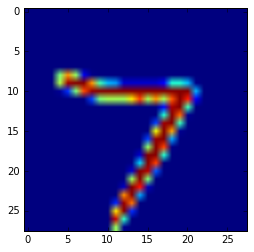

In [9]:
%matplotlib inline

# real
batch_x, batch_y= mnist.train.next_batch(m)
batch_x = np.reshape(batch_x, [-1,28,28,1])

imgplot = plt.imshow(batch_x[1,:,:,0])



In [10]:
# generated
batch_z = np.random.rand(m, z_size) -0.5
[batch_gz] = sess.run([gen_model], feed_dict= {g_dtrain.inputs : batch_z})
#[batch_gz] = sess.run([g_dtrain.y], feed_dict= {g_dtrain.inputs : batch_z})


In [11]:
#print(batch_z[1,:])
#print(batch_z[30,:])
#print('--------------')
#print(batch_gz[1,:])
#print(batch_gz[30,:])


print(batch_gz.shape)
idx= 0

(500, 784)


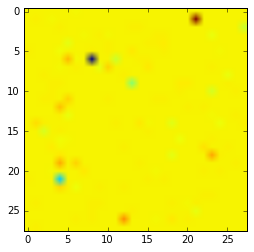

In [17]:
batch_gz = np.reshape(batch_gz, [-1,28,28,1])

#print(batch_gz[0,:,:,0])
imgplot = plt.imshow(batch_gz[idx,:,:,0]-batch_gz[idx+1,:,:,0])
idx +=1

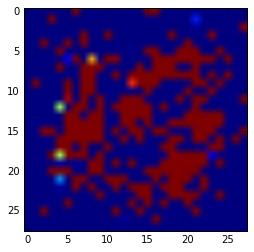

In [76]:
imgplot = plt.imshow(batch_gz[idx,:,:,0])
idx = idx+1